# Artificial Neural Networks with TensorFlow.Keras

In this notebook we will see how to use TensorFlow to train ANNs and avoid needing to extract features like we did in the previous notebook.

Let's grab the same digit data we used before!

In [121]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Counting objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 20.90 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
import os
os.chdir('free-spoken-digit-dataset/recordings')

In [123]:
import glob, os

wavfiles = list()
for file in glob.glob("*.wav"):
    wavfiles.append(file)

num_points = len(wavfiles)

print('{} data points\n'.format(num_points))

# list the first few files
wavfiles[:10]

1500 data points



['5_nicolas_11.wav',
 '8_nicolas_26.wav',
 '7_theo_47.wav',
 '0_jackson_25.wav',
 '0_nicolas_32.wav',
 '8_jackson_4.wav',
 '8_nicolas_20.wav',
 '9_theo_41.wav',
 '5_jackson_16.wav',
 '9_nicolas_47.wav']

In [0]:
import numpy as np
import scipy.io.wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn import metrics
import pandas as pd

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})

## Load the data

In [0]:
import re

re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d+.')

X_data = np.ndarray(shape=(num_points,),dtype=object)
y_labels = list()

label='digit'

In [126]:
ix = 0
for sample_file in wavfiles:
  try:
    
    digit = int(re.match( re_digit, sample_file)[0][:-1])
    speaker = re.search( re_speaker, sample_file)[0][1:-1]

    # read the file
    (sample_rate, signal) = scipy.io.wavfile.read(sample_file)
    
    # some files have two channels... just take the first one
    if len(signal.shape) == 2:
      signal = signal[:,0]
      
    
    X_data[ix,] = np.array(signal)
    
    ix+=1
    
    if label == 'speaker':
      y_labels.append(speaker)
      
    elif label == 'digit':
      y_labels.append(digit)
      
    else:
      print("I don't know what you want to predict...")
      break
      
    
  except Exception as e:
    
    # something went wrong!  =(
    
    print(sample_file)
    print(e)
    print(X_data.shape)
    print(signal.shape)
    
    break


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Normalize the inputs
Each .wav file is a different duration.  If we want to use the raw input as the signals, this will make our neural net cranky.  Let's artifically pad or truncate our input vectors so they're all the same length.  (Warning: we may lose data!)

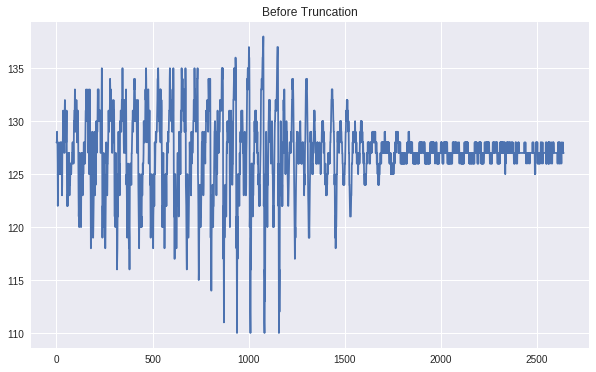

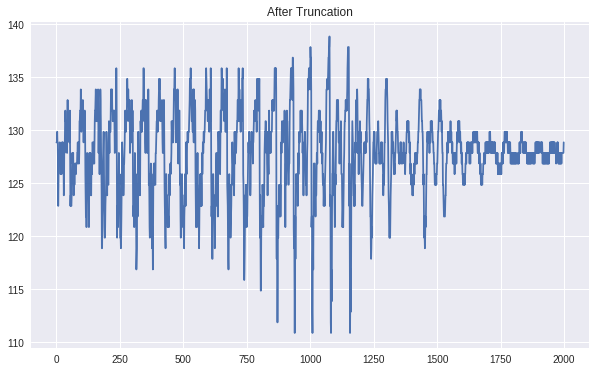

In [127]:
# Remove the mean from the data
# For each data point:
#   1) Remove the mean
#   2) Make the length = 2000
plt.figure()
plt.title("Before Truncation")
plt.plot(X_data[1])

desired_length = 2000

for i in range(len(X_data)):
  sig_len = len(X_data[i])
  if sig_len < desired_length:
    pad_len = desired_length - sig_len
    X_data[i] = np.append(X_data[i], np.mean(X_data[i])*np.ones(pad_len))
  else:
    X_data[i] = X_data[i][:desired_length]
  X_data -= np.mean(X_data[i])
  
plt.figure()
plt.title("After Truncation")
plt.plot(X_data[1])

In [128]:
# turn y_labels into categories (0,1,2)
y_labels = pd.Categorical(y_labels)
np.unique(y_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Split data into test/train split

In [0]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, np.array(y_labels), test_size=0.25)

In [130]:
print(X_train.shape)
print(y_train.shape)

(1125,)
(1125,)


## Reformat the labels

Next, we want to convert the labels from an integer format (e.g., "2"), to a [one hot encoding](https://en.wikipedia.org/wiki/One-hot) (e.g., "0, 0, 1, 0, 0, 0, 0, 0, 0, 0"). To do so, we'll use the `tf.keras.utils.to_categorical` [function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.

In [0]:
NUM_DIGITS = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes = NUM_DIGITS)
y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)

In [0]:
# The X data is in a variable-length array, which will make TensorFlow cranky... we're going to hack something together to fix that

X_train_df = pd.DataFrame()
for xx in X_train:
  X_train_df=X_train_df.append(pd.Series(xx),ignore_index=True)


X_test_df = pd.DataFrame()
for xx in X_test:
  X_test_df=X_test_df.append(pd.Series(xx),ignore_index=True)

## Build the model

Now, we'll create our neural network using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). 
* Architecture wise, we'll single layer network. 
* The hidden layer will have 512 units using the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation function. 
* The output layer will have 10 units and use [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) function. 
* Note: you will need to specify the input shape on the first layer. If you add subsequent layers, this is not necessary. 
* We will use the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) loss function, and the [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) optimizer.

In [133]:
# Build a fully-connected ANN with one hidden layer

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape = X_train[0].shape, activation=tf.nn.relu))   # hidden layer with 512 units and relu activation
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))   # output layer with 10 units and softmax activation
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 1,029,642
Trainable params: 1,029,642
Non-trainable params: 0
_________________________________________________________________


## Training

Next, we will train the model by using the [fit method](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for 10 [epochs](https://www.quora.com/What-is-epochs-in-machine-learning). We will keep track of the training loss and accuracy as we go. Please be patient as this step may take a while depending on your hardware.

Epoch 1/10
1125/1125 [==============================] - 1s 540us/step - loss: 14.3399 - acc: 0.1084
Epoch 2/10
1125/1125 [==============================] - 0s 392us/step - loss: 14.3724 - acc: 0.1067
Epoch 3/10
1125/1125 [==============================] - 0s 386us/step - loss: 14.2278 - acc: 0.1164
Epoch 4/10
1125/1125 [==============================] - 0s 391us/step - loss: 13.9321 - acc: 0.1333
Epoch 5/10
1125/1125 [==============================] - 0s 390us/step - loss: 13.8212 - acc: 0.1413
Epoch 6/10
1125/1125 [==============================] - 0s 394us/step - loss: 13.8685 - acc: 0.1387
Epoch 7/10
1125/1125 [==============================] - 0s 389us/step - loss: 13.7494 - acc: 0.1467
Epoch 8/10
1125/1125 [==============================] - 0s 422us/step - loss: 13.8661 - acc: 0.1396
Epoch 9/10
1125/1125 [==============================] - 0s 388us/step - loss: 13.8655 - acc: 0.1387
Epoch 10/10
1125/1125 [==============================] - 0s 388us/step - loss: 13.8257 - acc: 0.1422

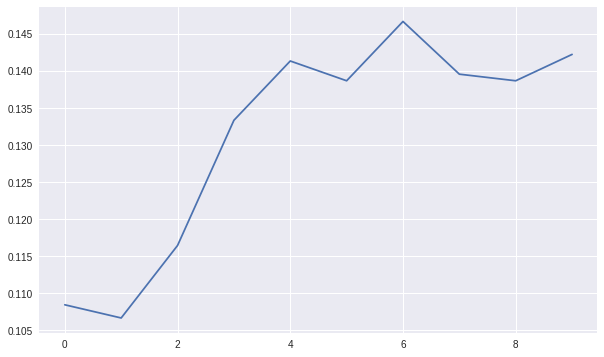

In [134]:
history = model.fit(X_train_df, y_train, epochs=10)

# plot metrics
plt.plot(history.history['acc'])
plt.show()

## Testing
Now that we have trained our model, we want to evaluate it. The training accuracy wasn't great (~35%, depending on the random seed), but better than random (10%).  Let's see how well we do on our test data.

In [135]:
loss, accuracy = model.evaluate(X_test_df, y_test)
print('Test accuracy: %.2f' % (accuracy))

375/375 [==============================] - 0s 216us/step
Test accuracy: 0.12


In [136]:
y_pred = model.predict_proba(X_test_df, verbose=1)

ix_pred = [np.argmax(y) for y in y_pred]
ix_true = [np.argmax(y) for y in y_test]

375/375 [==============================] - 0s 193us/step


In [0]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticks(range(len(labels)))
  ax.set_yticks(range(len(labels)))
  ax.set_xticklabels(labels, fontsize=16)
  ax.set_yticklabels(labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()

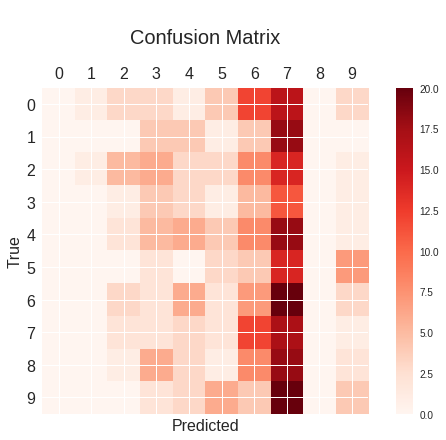

In [138]:
cm = metrics.confusion_matrix(ix_true,ix_pred, range(10))
plot_cmatrix(cm, range(10))

### Conclusions
As you can see, this is actually a pretty terrible classifier... 
* Play around with some of the model parameters to see if you can make it better.  Later we'll see how we can use convolutions to solve a similar problem!
* Try to see if you can train a better classifier using the frequency spectrum instead of the raw signal.  You won't have to pad/truncate the data because the data should all be the same size in the frequency domain (assuming they are all sampled at the same rate, which they are)!